# Transformer Experiments
I was thinking about how the attention layer in transformers literally just uses linear layers with a couple dot product operations. I wondered if such a process was learnable by a simple neural network, but in my brainstorm sesh with ChatGPT, it didn't like the idea. In the 'Attention is all you need' paper, they talk about how attention sort of reduces the path between dependencies in the input. Like, it allows the input to compare itself *to itself*. So, it's hard to replicate that with linear layers because in order to do so requires a significant amount of depth. Anyways, the key idea here is to make a sort of dot product layer with learnable parameters so that the model has more immediate access (without so much depth required) to compare a set of activations to itself. 

## Baseline
This is GPT-2, hopefully modifiable so that I can swap out its attention. If not, that's just embarrassing.

### prompt

I'm experimenting with a new architecture for a transformer. I only have my rtx 3090 laptop gpu, for now, which has 16gb memory. I'd like to be able to train a transformer, with passable results, just on my machine, so I need a baseline model and dataset which are small enough in resources for me to be able to iterate fairly quickly as I tinker with the model structure. I'd like it to be a decoder-only model, as well. 
Given your constraints, you can start by working with a small-scale decoder-only transformer model and a modestly-sized dataset. Here's a suggestion for the baseline model and dataset:

Baseline Model:
Since you want a decoder-only model, you can use a scaled-down version of GPT-2 as your baseline. The GPT-2 architecture is based on the Transformer architecture and is designed for text generation tasks. To fit your GPU memory, you can reduce the number of layers (transformer blocks) and the hidden size of the model, as well as the number of attention heads.

For example, instead of using the original GPT-2 configuration with 12 layers, 768 hidden units, and 12 attention heads, you could experiment with a smaller model, such as 4 layers, 256 hidden units, and 4 attention heads.

Dataset:
A suitable dataset would be small enough to fit in your GPU memory and enable quick experimentation but still diverse enough to allow your model to learn meaningful representations. One possible option is the "WikiText-2" dataset, a collection of Wikipedia articles containing over 2 million tokens. This dataset is widely used for language modeling tasks and is smaller than the "WikiText-103" dataset.

Training:
To accelerate training, you can use mixed-precision training, which leverages half-precision (float16) arithmetic to reduce memory usage and training time. Additionally, you can experiment with gradient accumulation to further fit your model within the GPU memory constraints.

Remember to start with a smaller batch size and lower learning rate to accommodate your GPU's memory limitations, and gradually increase them if possible. Monitor the training loss and performance on a validation set to ensure that the model is learning effectively.

Once you have established a baseline with the scaled-down GPT-2 model and WikiText-2 dataset, you can start experimenting with your new architecture and compare its performance against the baseline.

### code

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.optim import AdamW


In [2]:
class WikiText2Dataset(Dataset):
    def __init__(self, data_path, tokenizer, seq_length):
        with open(data_path, "r") as file:
            text = file.read()

        self.tokenizer = tokenizer

        # Split the text into smaller chunks and tokenize them
        chunk_size = seq_length * 10
        text_chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
        tokenized_chunks = []

        for chunk in text_chunks:
            tokenized_chunk = tokenizer(chunk, return_tensors="pt", add_special_tokens=True)["input_ids"]
            if tokenized_chunk.size(1) < seq_length:
                tokenized_chunk = torch.cat([tokenized_chunk, torch.zeros(1, seq_length - tokenized_chunk.size(1), dtype=torch.long)], dim=1)
            tokenized_chunks.append(tokenized_chunk)

        # Create input sequences with the specified sequence length
        self.inputs = []

        for tokenized_chunk in tokenized_chunks:
            for i in range(0, tokenized_chunk.size(1) - seq_length, seq_length):
                input_sequence = tokenized_chunk[0, i:i + seq_length]
                self.inputs.append(input_sequence)

        self.inputs = torch.stack(self.inputs)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]

In [3]:
# Initialize the tokenizer and the dataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", padding_side="left")
tokenizer.pad_token_id = tokenizer.eos_token_id
print(f'pad_token: {tokenizer.pad_token}, pad_token_id: {tokenizer.pad_token_id}')
seq_length = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

train_dataset = WikiText2Dataset("wikitext-2-raw/wiki.train.raw", tokenizer, seq_length)

data_on_gpu = False
if data_on_gpu:
    # Convert the entire dataset to a tensor and move it to the GPU
    print('Converting the entire dataset to a tensor and moving it to the GPU')
    train_dataset = torch.stack([sample.to(device) for sample in train_dataset])

Token indices sequence length is longer than the specified maximum sequence length for this model (2129 > 1024). Running this sequence through the model will result in indexing errors


pad_token: <|endoftext|>, pad_token_id: 50256


In [4]:
# Create a DataLoader
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_dataset))
print("Number of batches:", len(train_loader))

# Define the model configuration and instantiate the GPT-2 model
# config = GPT2Config(
#     vocab_size=tokenizer.vocab_size,
#     n_positions=tokenizer.max_model_input_sizes["gpt2"],
#     n_ctx=tokenizer.max_model_input_sizes["gpt2"],
#     n_embd=256,
#     n_layer=4,
#     n_head=4,
#     activation_function="gelu"
# )

# Load a pretrained GPT-2 model
pretrained_model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define the model configuration and instantiate the GPT-2 model
config = pretrained_model.config
print(f'config: {config}')

baseline_model = GPT2LMHeadModel(config)
baseline_model.load_state_dict(pretrained_model.state_dict())  # Transfer the weights to the baseline model
baseline_model.to(device)

num_epochs = 400
learning_rate = 2e-4
warmup_steps = 50  # Reduce the warmup steps to ensure the warmup_fraction is within the expected range.
max_len = seq_length

def setup(model_for_training):
    optimizer = AdamW(model_for_training.parameters(), lr=learning_rate)
    print(f'train_loader length: {len(train_loader)}')
    warmup_fraction = warmup_steps / (len(train_loader) * num_epochs)
    print("Warmup fraction:", warmup_fraction)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=len(train_loader) * num_epochs, pct_start=warmup_fraction)
    return optimizer, scheduler
baseline_optimizer,baseline_scheduler = setup(baseline_model)

Number of training samples: 2084
Number of batches: 1042
config: GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 50257
}

train_loader length: 1042
Warmup fraction: 0

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

def plot_loss_graph(losses, epoch):
    clear_output(wait=True)  # Clear the output of the current cell
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title(f"Loss graph at epoch {epoch}")
    plt.show()

def left_pad(input_ids, pad_token_id, max_length):
    pad_length = max_length - input_ids.shape[1]
    padding = torch.full((1, pad_length), pad_token_id, dtype=torch.long, device=input_ids.device)
    return torch.cat([padding, input_ids], dim=1)

def generate_sample(model_to_sample, tokenizer, prompt, max_length=max_len):
    input_ids = tokenizer.encode(
        prompt,
        return_tensors="pt",
        truncation=True
    ).to(device)
    # print(f"input_ids shape: {input_ids.shape}")
    
    for x in range(20):
        # Pad the input sequence to max_length (32) with left padding
        input_ids = left_pad(input_ids, tokenizer.pad_token_id, max_length)
        print(f"prompting model with: {tokenizer.decode(input_ids[0], skip_special_tokens=True)}")
        with torch.no_grad():
            output_ids = model_to_sample.generate(input_ids, max_length=max_length+1, pad_token_id=tokenizer.eos_token_id, repetition_penalty=0.5, do_sample=True)

        # Remove padding tokens from the output sequence
        output_ids_no_padding = output_ids[output_ids != tokenizer.pad_token_id]
        input_ids = output_ids_no_padding.unsqueeze(0)

    print(f"output_ids_no_padding shape: {output_ids_no_padding.shape}")
    return tokenizer.decode(output_ids_no_padding, skip_special_tokens=True)


    # attention_mask = (input_ids != tokenizer.pad_token_id).to(device)  # Create the attention mask
    # with torch.no_grad():
        # output_ids = model.generate(input_ids, max_length=max_length, attention_mask=attention_mask)  # Pass the attention mask to the model
       

def train(model_for_training, optimizer, scheduler):
    # Train the model
    model_for_training.train()
    losses = []

    for epoch in range(num_epochs):
        for step, batch in enumerate(train_loader):
            input_ids = batch.to(device)
            outputs = model_for_training(input_ids, labels=input_ids)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            losses.append(loss.item())

        plot_loss_graph(losses, epoch + 1)

        # Switch to evaluation mode
        model_for_training.eval()

        # Generate a sample inference
        prompt = "In a shocking turn of events,"
        generated_text = generate_sample(model_for_training, tokenizer, prompt)
        print(f"Generated text at epoch {epoch + 1}: {generated_text}")

        # Switch back to training mode
        model_for_training.train()


    # Plot the final loss graph
    plot_loss_graph(losses, 'Final')


    # Generate a sample inference
    model_for_training.eval()
    prompts = ["In a shocking turn of events,", "The president of the United States", "The stock market crash of"]
    for prompt in prompts:
        generated_text = generate_sample(model_for_training, tokenizer, prompt)
        print(f"Generated text: {generated_text}")

    return losses


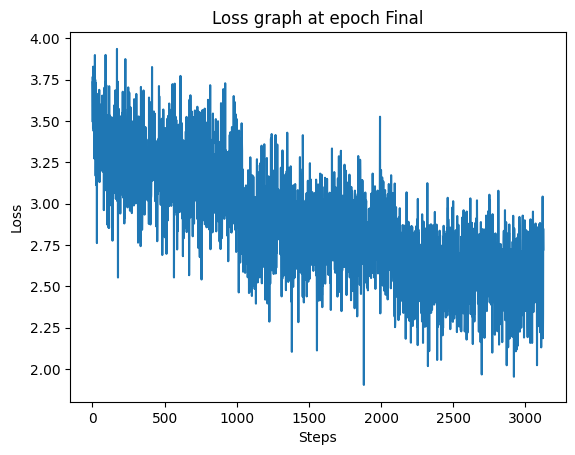

prompting model with: In a shocking turn of events,
prompting model with: In a shocking turn of events,,
prompting model with: In a shocking turn of events,,,
prompting model with: In a shocking turn of events,,, a
prompting model with: In a shocking turn of events,,, a,
prompting model with: In a shocking turn of events,,, a, of
prompting model with: In a shocking turn of events,,, a, of the
prompting model with: In a shocking turn of events,,, a, of the,
prompting model with: In a shocking turn of events,,, a, of the,,
prompting model with: In a shocking turn of events,,, a, of the,, a
prompting model with: In a shocking turn of events,,, a, of the,, a,
prompting model with: In a shocking turn of events,,, a, of the,, a, a
prompting model with: In a shocking turn of events,,, a, of the,, a, a,
prompting model with: In a shocking turn of events,,, a, of the,, a, a, a
prompting model with: In a shocking turn of events,,, a, of the,, a, a, a,
prompting model with: In a shocking turn of 

In [6]:
og_losses = train(baseline_model, baseline_optimizer, baseline_scheduler)

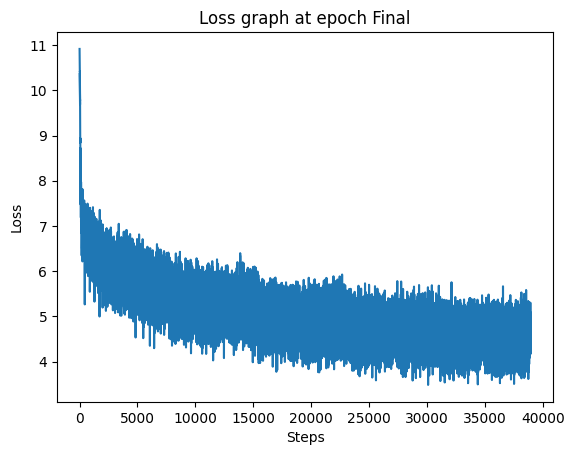     
     
Generated text: In a shocking turn of events,@ 000 people, the player can be used to be a player. 
 
 = = = = = = = = = = = = = = = = = = = = = = = = =

## Experiment Time!
I've created a Dot Product Interaction Layer, which aims to provide that functionality to compare one set of activations with itself or others directly. Attention seems like it does that. So, I hope that attention emerges from the usage of this layer. I'm going to try to use it in the transformer used above and see what happens.

In [7]:
# I've created a Dot Product Interaction Layer, which aims to provide that functionality to compare one set of activations with itself or others directly. Attention seems like it does that. So, I hope that attention emerges from the usage of this layer. I'm going to try to use it in the transformer used above and see what happens.
import torch
import torch.nn as nn
import torch.nn.functional as F

class DotProductInteractionLayer(nn.Module):
    """
    The last two dimensions of x are matrix-multiplied with the last 
    two dimensions of y transposed. A linear layer is applied to the resulting matrix, acting as the interaction arbiter,
    whose output is the same shape as the x and y. A relu activation is applied, acting as the threshold.
    
    Args:
        input_dim (int): The size of the input tensor's last dimension.
        threshold (float, optional): The threshold value for the interaction matrix.
                                     Elements with an absolute value below the threshold
                                     will be set to zero. Default is 0.0.
    """
    def __init__(self, input_dim, n_head, config, threshold=0.0):
        super(DotProductInteractionLayer, self).__init__()
        print(f'context_length: {input_dim}, input_dim: {input_dim}, n_head: {n_head}')
        self.input_dim = input_dim
        self.n_head = n_head
        self.threshold = threshold
        # self.interaction_matrix = nn.Parameter(torch.randn(input_dim // n_head, input_dim // n_head))
        self.scale = torch.sqrt(torch.tensor(input_dim // n_head, dtype=torch.float32))
        # self.scale = torch.sqrt(torch.tensor(input_dim, dtype=torch.float32))
        self.max_seq_len = seq_length #config.n_ctx
        self.hidden_size = config.hidden_size
        # self.linear = nn.Linear(self.max_seq_len, input_dim // n_head, bias=True)
        self.linear = nn.Linear(self.max_seq_len, input_dim, bias=True)
        # self.linear = nn.Linear(32, input_dim // n_head, bias=True)
        # self.linear = nn.Linear(input_dim // n_head, input_dim // n_head, bias=True)
        # self.linear = nn.Linear(32, input_dim // n_head, bias=True)
        print(f'linear weight shape: {self.linear.weight.shape}')
        self.embed_dim = config.hidden_size
        print(f'embed_dim: {self.embed_dim}')
        print(f'context_length: {config.n_ctx}')

    @staticmethod
    def pad_input(tensor, max_seq_len):
        pad_size = max_seq_len - tensor.size(-2)
        if pad_size > 0:
            tensor = F.pad(tensor, (0, 0, 0, pad_size))
        return tensor

    def forward(self, x):
        """
        Forward pass of the DotProductInteractionLayer. The last two dimensions of x are matrix-multiplied with the last 
        two dimensions of y transposed. A linear layer is applied to the resulting matrix, acting as the interaction arbiter,
        whose output is the same shape as the x and y. A relu activation is applied, acting as the threshold.

        TODO: consider adding that sqrt(dk) scaling factor and the softmax to each row of the matrix multiplication result.

        Args:
            x (torch.Tensor): The first input tensor of shape (batch_size * n_head, sequence_length, input_dim // n_head).
            y (torch.Tensor): The second input tensor of shape (batch_size * n_head, sequence_length, input_dim // n_head).

        Returns:
            interaction_output (torch.Tensor): Output tensor of shape (batch_size, n_head, sequence_length, sequence_length),
                                            representing the dot product interaction between the input tensors.
        """
        # print(f'x shape: {x.shape}')
        x = self.pad_input(x, self.max_seq_len)
        # print(f'x shape: {x.shape}')
        x_copy = x.clone()

        interaction = torch.matmul(x, x_copy.transpose(-1, -2)) / self.scale
        interaction_softmax = F.softmax(interaction, dim=-1)
        interaction_output = self.linear(interaction_softmax)

        # restore to proper shape
        # interaction_output = interaction_output.view(-1, interaction_output.size(1), self.hidden_size)

        return interaction_output


In [8]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Model, GPT2Block, GPT2LMHeadModel, GPT2MLP
from typing import Optional, Tuple, Union

class CustomGPT2BlockNoAttention(nn.Module):
    def __init__(self, config, layer_idx=None):
        super().__init__()
        hidden_size = config.hidden_size
        inner_dim = config.n_inner if config.n_inner is not None else 4 * hidden_size
        n_head = config.n_head

        self.ln_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.dot_product_interaction = DotProductInteractionLayer(hidden_size, n_head, config)
        self.ln_2 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.mlp = GPT2MLP(inner_dim, config)

    def forward(
        self,
        hidden_states: torch.Tensor,
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = False,
    ) -> Union[Tuple[torch.Tensor], Optional[Tuple[torch.Tensor, Tuple[torch.FloatTensor, ...]]]]:
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        interaction_output  = self.dot_product_interaction(hidden_states)
        # print(f'interaction_output shape: {interaction_output.shape}, residual shape: {residual.shape}')
        hidden_states = interaction_output + residual

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        hidden_states = residual + feed_forward_hidden_states

        return (hidden_states, [])


class CustomGPT2Model(GPT2Model):
    def __init__(self, config):
        super().__init__(config)

        # Replace the GPT2Block layer with the CustomGPT2Block layer
        self.h = nn.ModuleList([CustomGPT2BlockNoAttention(config, layer_idx=i) for i in range(config.n_layer)])


class CustomGPT2LMHeadModel(GPT2LMHeadModel):
    def __init__(self, config):
        super().__init__(config)

        # Replace the GPT2Model with the CustomGPT2Model
        self.transformer = CustomGPT2Model(config)


In [9]:
# custom_model = CustomGPT2LMHeadModel(config)
# custom_model.to(device)

custom_model = CustomGPT2LMHeadModel(config)
custom_model.load_state_dict(pretrained_model.state_dict(), strict=False)  # Transfer the weights to the custom model
custom_model.to(device)

context_length: 768, input_dim: 768, n_head: 12
linear weight shape: torch.Size([768, 1024])
embed_dim: 768
context_length: 1024
context_length: 768, input_dim: 768, n_head: 12
linear weight shape: torch.Size([768, 1024])
embed_dim: 768
context_length: 1024
context_length: 768, input_dim: 768, n_head: 12
linear weight shape: torch.Size([768, 1024])
embed_dim: 768
context_length: 1024
context_length: 768, input_dim: 768, n_head: 12
linear weight shape: torch.Size([768, 1024])
embed_dim: 768
context_length: 1024
context_length: 768, input_dim: 768, n_head: 12
linear weight shape: torch.Size([768, 1024])
embed_dim: 768
context_length: 1024
context_length: 768, input_dim: 768, n_head: 12
linear weight shape: torch.Size([768, 1024])
embed_dim: 768
context_length: 1024
context_length: 768, input_dim: 768, n_head: 12
linear weight shape: torch.Size([768, 1024])
embed_dim: 768
context_length: 1024
context_length: 768, input_dim: 768, n_head: 12
linear weight shape: torch.Size([768, 1024])
embe

CustomGPT2LMHeadModel(
  (transformer): CustomGPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): CustomGPT2BlockNoAttention(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dot_product_interaction): DotProductInteractionLayer(
          (linear): Linear(in_features=1024, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): CustomGPT2BlockNoAttention(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dot_product_interaction): DotProductInteractionLayer(
          (linear): Linear(in_features=1024, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, el

In [10]:
custom_optimizer, custom_scheduler = setup(custom_model)

train_loader length: 1042
Warmup fraction: 0.01599488163787588


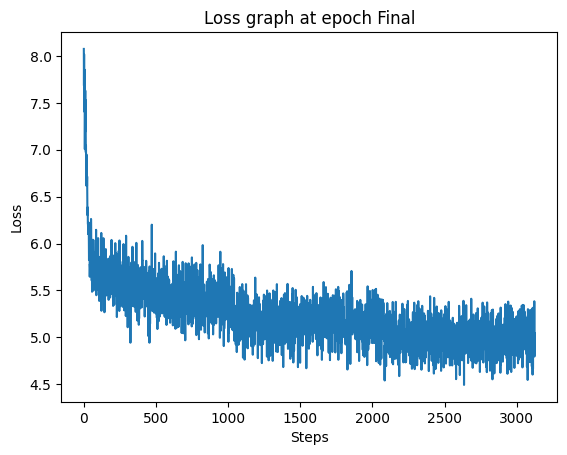

prompting model with: In a shocking turn of events,
prompting model with: In a shocking turn of events, a
prompting model with: In a shocking turn of events, a period
prompting model with: In a shocking turn of events, a period of
prompting model with: In a shocking turn of events, a period of a
prompting model with: In a shocking turn of events, a period of a significant
prompting model with: In a shocking turn of events, a period of a significant influence
prompting model with: In a shocking turn of events, a period of a significant influence of
prompting model with: In a shocking turn of events, a period of a significant influence of a
prompting model with: In a shocking turn of events, a period of a significant influence of a large
prompting model with: In a shocking turn of events, a period of a significant influence of a large of
prompting model with: In a shocking turn of events, a period of a significant influence of a large of a
prompting model with: In a shocking turn of even

In [11]:
new_losses = train(custom_model, custom_optimizer, custom_scheduler)

In [12]:
# query shape: torch.Size([6, 4, 32, 64]), key shape: torch.Size([6, 4, 32, 64])
# batch_size: 1, n_head: 4, sequence_length: 32, input_dim: 1024
# attempted reshaped query shape: (4, 32, 256)


# shape of attn_weights: torch.Size([8, 4, 32, 32])
# shape of attn_output: torch.Size([8, 4, 32, 64]), shape of attn_weights: torch.Size([8, 4, 32, 32])

In [16]:
# Generate a sample inference
baseline_model.eval()
prompts = ["In a shocking turn of events,", "The president of the United States", "The stock market crash of"]
for prompt in prompts:
    generated_text = generate_sample(baseline_model, tokenizer, prompt)
    print(f"Generated text: {generated_text}")

prompting model with: In a shocking turn of events,
prompting model with: In a shocking turn of events, A
prompting model with: In a shocking turn of events, A first
prompting model with: In a shocking turn of events, A first of
prompting model with: In a shocking turn of events, A first of the
prompting model with: In a shocking turn of events, A first of the first
prompting model with: In a shocking turn of events, A first of the first of
prompting model with: In a shocking turn of events, A first of the first of the
prompting model with: In a shocking turn of events, A first of the first of the first
prompting model with: In a shocking turn of events, A first of the first of the first a
prompting model with: In a shocking turn of events, A first of the first of the first a first
prompting model with: In a shocking turn of events, A first of the first of the first a first of
prompting model with: In a shocking turn of events, A first of the first of the first a first of the
prompting

In [14]:
# Generate a sample inference
custom_model.eval()
prompts = ["In a shocking turn of events,", "The president of the United States", "The stock market crash of"]
for prompt in prompts:
    generated_text = generate_sample(custom_model, tokenizer, prompt)
    print(f"Generated text: {generated_text}")

prompting model with: In a shocking turn of events,
prompting model with: In a shocking turn of events, a
prompting model with: In a shocking turn of events, a very
prompting model with: In a shocking turn of events, a very difficult
prompting model with: In a shocking turn of events, a very difficult to
prompting model with: In a shocking turn of events, a very difficult to a
prompting model with: In a shocking turn of events, a very difficult to a "
prompting model with: In a shocking turn of events, a very difficult to a " a
prompting model with: In a shocking turn of events, a very difficult to a " a total
prompting model with: In a shocking turn of events, a very difficult to a " a total of
prompting model with: In a shocking turn of events, a very difficult to a " a total of a
prompting model with: In a shocking turn of events, a very difficult to a " a total of a little
prompting model with: In a shocking turn of events, a very difficult to a " a total of a little "
prompting mo

In [15]:
import pandas as pd
from ipywidgets import interact, widgets

def plot_loss_graph(losses_baseline, losses_custom, epoch, smoothing_factor):
    clear_output(wait=True)  # Clear the output of the current cell
    
    # Apply smoothing to the loss values
    losses_baseline_smoothed = pd.Series(losses_baseline).rolling(window=smoothing_factor, min_periods=1, center=True).mean()
    losses_custom_smoothed = pd.Series(losses_custom).rolling(window=smoothing_factor, min_periods=1, center=True).mean()

    plt.plot(losses_baseline_smoothed, label='Baseline Model', color='blue')
    plt.plot(losses_custom_smoothed, label='Custom Model', color='green')
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title(f"Loss graph at epoch {epoch} with smoothing factor {smoothing_factor}")
    plt.legend()
    plt.show()

# Interactive slider for the smoothing factor
@interact(smoothing_factor=widgets.IntSlider(min=1, max=100, step=1, value=10))
def interactive_plot_loss_graph(smoothing_factor):
    plot_loss_graph(og_losses, new_losses, 'Final', smoothing_factor)


interactive(children=(IntSlider(value=10, description='smoothing_factor', min=1), Output()), _dom_classes=('wi…